# Library imports, configurations

In [2]:
import io
import os
import cv2
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import subprocess
import seaborn as sns
import s3fs
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from PIL import Image
import pyvips
import torch
from joblib import dump
from pathlib import Path
import random
from tqdm import tqdm
from cloudpathlib import S3Path, S3Client, CloudPath
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xgboost as xgb
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingClassifier
# import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# import tensorflow_decision_forests as tfdf
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image

In [3]:
if torch.cuda.is_available() : device= torch.device("cuda:0" ) 
else : device  = "cpu"
print("Using {} device".format(device))
if device != "cpu" :
    print("nom du GPU :", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

Using cpu device


In [4]:
Image.MAX_IMAGE_PIXELS = None

In [5]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [6]:
BUCKET = "jplaton/diffusion"
fs.ls(BUCKET)

['jplaton/diffusion/.keep',
 'jplaton/diffusion/ted',
 'jplaton/diffusion/visio_mel']

# DATA Download

## Metadata and labels

In [7]:
FILE_PATH_TRAIN = "visio_mel/train_labels.csv"
FILE_PATH_TRAIN_S3 = BUCKET + "/" + FILE_PATH_TRAIN

with fs.open(FILE_PATH_TRAIN_S3, mode="rb") as file_in:
    train_labels = pd.read_csv(file_in, sep=",")

In [8]:
FILE_PATH_TRAIN = "visio_mel/train_metadata.csv"
FILE_PATH_TRAIN_S3 = BUCKET + "/" + FILE_PATH_TRAIN

with fs.open(FILE_PATH_TRAIN_S3, mode="rb") as file_in:
    train_metadata = pd.read_csv(file_in, sep=",")

In [10]:
FILE_PATH_TEST = "visio_mel/visiomel_code_execution_development_data/test_labels.csv"
FILE_PATH_TEST_S3 = BUCKET + "/" + FILE_PATH_TEST

with fs.open(FILE_PATH_TEST_S3, mode="rb") as file_in:
    test_labels = pd.read_csv(file_in, sep=",")

In [11]:
FILE_PATH_TEST = "visio_mel/visiomel_code_execution_development_data/test_metadata.csv"
FILE_PATH_TEST_S3 = BUCKET + "/" + FILE_PATH_TEST

with fs.open(FILE_PATH_TEST_S3, mode="rb") as file_in:
    test_metadata = pd.read_csv(file_in, sep=",")

## Images

In [12]:
# select a set of images to plot
SEED = 42
NUM_IMAGES = 3

# we'll use the US url
selected_image_paths = train_metadata.sample(
    random_state=SEED, n=NUM_IMAGES
).us_tif_url.values

In [13]:
def visualize_page(page_num, image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(10, 10))
    fig.tight_layout()

    for n, image_s3_path in enumerate(image_paths):
        fname = S3Path(image_s3_path).name
        print(f"Downloading {fname}")
        local_file = S3Path(image_s3_path,client = S3Client(no_sign_request=True)).fspath #local_cache_dir='/tmp/images', 

        n_frames = Image.open(local_file).n_frames
        img = pyvips.Image.new_from_file(local_file, page=page_num).numpy()

        axes[n].set_title(f"{fname}, page={page_num}\n {img.shape}\n")
        axes[n].imshow(img)

In [ ]:
# let's look at a few high-resolution pages from our selected images
visualize_page(3, selected_image_paths)

In [ ]:
# let's look at low-resolution pages from the same images
visualize_page(8, selected_image_paths)

In [32]:
img = pyvips.Image.new_from_file('../data/images/9k10x5h3.tif', page=8) #.numpy()

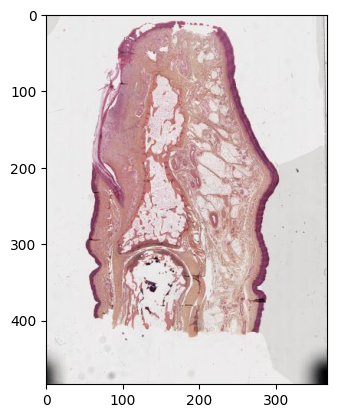

In [33]:
plt.imshow(img)

In [34]:
format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

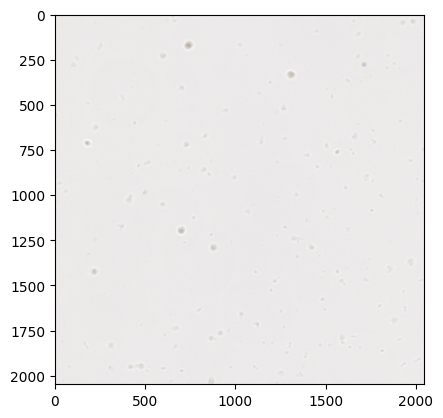

In [43]:
image = pyvips.Image.new_from_file('../data/images/9k10x5h3.tif')

patch = image.crop(10000, 10000, 2048, 2048)

np_img = np.ndarray(buffer=patch.write_to_memory(),
                   dtype=format_to_dtype[patch.format],
                   shape=[patch.height, patch.width, patch.bands])
plt.imshow(np_img)

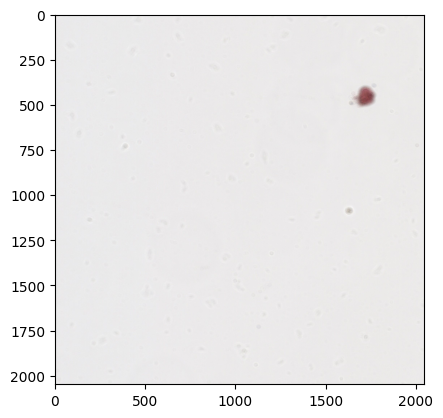

### Création du dataset d'images

In [ ]:
train_images_file = os.listdir("../data/images")

In [ ]:
train_labels_im = train_labels.copy()
train_labels_im = train_labels_im[train_labels_im['filename'].isin(train_images_file)]

In [ ]:
train_metadata_im = train_metadata.copy()
train_metadata_im = train_metadata_im[train_metadata_im['filename'].isin(train_images_file)]
train_metadata_im['filepaths'] = '../data/images/'+ train_metadata_im['filename']

In [ ]:
train_images_paths = np.array(train_metadata_im['filepaths'])
train_images_labels = np.array(train_labels_im['relapse'])

In [ ]:
train_images_labels

In [ ]:
# train_images_name = np.array(train_metadata['filename'])
# train_images_labels_all = np.array(train_labels['relapse'])

In [ ]:
tabular_df = X.copy()
tabular_df = tabular_df[tabular_df['filename'].isin(train_images_file)]

In [ ]:
# Création de la classe permettant d'accéder au dataset
# On crée ici la classe Custom Dataset héritant de la classe Dataset en python
# Un CustomDataset sera initialisé avec l'ensemble des images_paths et ses labels précedemment présentés.
# Un objet Dataset sera dit itérable dans la mesure où on pourra boucler dessus pour en récupérer les éléments. A chaque itération d'une telle boucle La fonction getitem  sera appelée pour accéder à un élément. 
# Ci-dessous on demande à chaque itération de retourner un dictionnnaire dont les items (clef,valeur)  sont : 
# ('image', l'image sous forme d'array ) ('label', le label associé (0,1))

class CustomDataset(Dataset):
    def __init__(self, image_paths,labels,tabular_df): 
        self.image_paths = image_paths
        self.labels = labels
        self.tabular = tabular_df
        
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.tabular.iloc[idx, 0:]
        
        #local_file = S3Path('s3://drivendata-competition-visiomel-public-us/images/'+self.image_paths[idx],client=S3Client(local_cache_dir='/tmp/images',no_sign_request=True)).fspath 
        #image = pyvips.Image.new_from_file(local_file, page=3).numpy()
        image = pyvips.Image.new_from_file(self.image_paths[idx], page=3).numpy()  
        image = cv2.resize(image, (512, 512))
        image = torch.tensor(np.array(image,dtype = float)/255, dtype =torch.float).permute(2,1,0)     
        label = self.labels[idx]
        #os.remove(local_file)

        tabular = tabular[['age_int','sex','resolution','melanoma_history_YES', 'melanoma_history_nan', 'body_site_face',
       'body_site_finger', 'body_site_foot', 'body_site_forearm',
       'body_site_hand', 'body_site_hand_foot_nail',
       'body_site_head_neck', 'body_site_leg', 'body_site_lower_limb_hip',
       'body_site_nail', 'body_site_neck', 'body_site_scalp',
       'body_site_seat', 'body_site_sole', 'body_site_thigh',
       'body_site_toe', 'body_site_trunc', 'body_site_trunk',
       'body_site_upper_limb_shoulder', 'body_site_nan']]

        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)
        
     
        return {"image": image, "tabular": tabular, "label" : label} 
        
        
    def __len__(self):  # return count of sample we have
        return len(self.image_paths)

###  Définition de quelques hyper paramètres

In [ ]:
NB_CLASSES = 2
config ={
    'n_epoch' : 100,
    'val_size' : 0.20,
    'batch_size' : 4,
    'optimizer' : "SGD",
    'lr' : 0.005,
    'momentum' : 0.9,
    'model type': "convnet",
    'descriptif': "Entrainement avec un convnet"
}

### Création des Data Loader
Dans un premier temps on va découper notre jeu d'apprentissage (les 366 images labellisées) en : 
un jeu de d'entraînement sur lequel on  entraînera notre modèle un jeu de validation ne participant pas à l'entrainement du modèle mais permettant d'en évaluer les performances
La fonction train_test_split de scikit learn permet de faire ce découpage. Le paramètre val_size de la config donne la proportion ddu jeu d'images total (entre 0 et 1) que l'on veut garder dans le jeu de validation. Le paramètre stratify permet de préciser sur quel critère on veut stratifier cette sélection aléatoire (ici les labels dans le but d'avoir un échantillon représentatif des labels de l'ensemble des images)Lors de l'entraînement, on va en fait entrainer notre algorithme par itération sur des petits paquets d'images (appelés batchs). On calcule pour chacun de ces batchs l'erreur commise par l'algorithme et on modifie ses paramètres en conséquence (par descente de gradient)Cette extraction par paquet d'images est permise par le Dataloader moyenant le remplissage du paramètre batch_size (cf 'batch_size' dans la config) permettant de préciser la taille des batchs que l'on souhaite avoir. Le paramètre shuffle égal à True veut dire que les images seront toutes remélangées une fois un tour total de l'ensemble des images réalisé. 
On appelle un tour complet une epoch.

In [ ]:
batch_size =  config['batch_size']
all_dataset = CustomDataset(train_images_paths,train_images_labels,tabular_df)
#all_dataset = CustomDataset(train_images_name,train_images_labels_all)

# je découpe le data set en train et validation (20 % de validation) en stratifiant par les labels
train_indices, valid_indices = train_test_split(list(range(len(train_images_labels))), test_size=config['val_size'], stratify=train_images_labels)
#train_indices, valid_indices = train_test_split(list(range(len(train_images_labels_all))), test_size=config['val_size'], stratify=train_images_labels_all)

train_dataset = torch.utils.data.Subset(all_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(all_dataset, valid_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Définition des modèles
 On définit ici une classe Net (héritant de la classe module) permettant d'instancier des réseaux de neurones convolutifs.Dans init, on définit l'ensemble des objets utilisés dans l'opération forward.L'opération forward définit la suite des opérations qui seront appliquées aux images auxquelles on appliquera un modèle de type Net.Dans la fonction forward (qui prend en entrée une image x) on constate bien que plusieurs transformations enboitées sont successivement appliquées à l'image x en entrée.

In [ ]:
def conv_block(input_size, output_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, (3, 3)), nn.ReLU(), nn.BatchNorm2d(output_size), nn.MaxPool2d((2, 2)),
    )

    return block

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 16)
        self.conv2 = conv_block(16, 32)
        self.conv3 = conv_block(32, 64)

        self.ln1 = nn.Linear(246016, 16)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout2d(0.5)
        self.ln2 = nn.Linear(16, 5)

        self.ln4 = nn.Linear(25, 10)
        self.ln5 = nn.Linear(10, 10)
        self.ln6 = nn.Linear(10, 5)
        self.ln7 = nn.Linear(10, NB_CLASSES)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.conv3 = nn.Conv2d(16, 32, 4)
        # self.conv4 = nn.Conv2d(32, 16, 3)
        # self.conv5 = nn.Conv2d(16, 24, 3)
        # self.fc1 = nn.Linear(256, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, NB_CLASSES)
        
    def forward(self, img, tab):
        
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        img = img.reshape(img.shape[0], -1)
        img = self.ln1(img)
        img = self.relu(img)
        img = self.batchnorm(img)
        img = self.dropout(img)
        img = self.ln2(img)
        img = self.relu(img)

        tab = self.ln4(tab)
        tab = self.relu(tab)
        tab = self.ln5(tab)
        tab = self.relu(tab)
        tab = self.ln6(tab)
        tab = self.relu(tab)

        x = torch.cat((img, tab), dim=1)
        x = self.relu(x)

        return self.ln7(x)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        # x = self.pool(F.relu(self.conv4(x)))
        # x = self.pool(F.relu(self.conv5(x)))
        # x = torch.flatten(x, 1)# flatten all dimensions except batch
        # #print(x.size())
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x

###  Test Modèle

In [ ]:
net = Net()

In [ ]:
 def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(net) 

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=config['lr'])
net = net.to(device)

entropy = nn.CrossEntropyLoss() 

liste_loss = []
liste_acc_val = []
for epoch in range(config['n_epoch']):  
    
    net = net.to(device)
    running_loss = 0.0

    t= tqdm(train_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
    epoch_loop = enumerate(t)

    for i, data in epoch_loop:
        
        taille_batch = data['image'].shape[0]
        images = data['image']
        labels  =  data['label']
        tabular = data['tabular']
            
        images, labels, tabular = images.to(device), labels.to(device), tabular.to(device)

        pred = net(images,tabular)
            
        # zero the parameter gradients
        optimizer.zero_grad()

        loss = entropy(pred,labels)
            
        loss.backward() # calculer le gradient
        optimizer.step() # avancer dans le sens du gradient calculé

        del images, labels, pred
        running_loss += loss.item()

        if (i+1) % 10 == 0:  
            # ici enregistrement de la loss sur le train, sur le validation et envoi des résultats à wnandb
            liste_loss.append(running_loss)

            # validation
            ech_val = iter(valid_loader)
            dico = next(ech_val)
            images =dico["image"]
            labels =dico["label"]
            tabular =dico["tabular"]

            pred = torch.argmax(net(images.to(device),tabular.to(device)),dim =1)
            labels = labels.to(device)
                
            acc_val =round(100*int(torch.sum(pred == labels).cpu())/int(np.array(labels.size())),2)
            liste_acc_val.append(acc_val)
            t.set_description("epoch %i, 'mean loss: %.6f','acc.val: %.2f'" % (epoch+1,running_loss/10,acc_val))
            t.refresh()
                
            running_loss =0

###  Evaluation du réseau entraîné
 Lors de l'entraînement, les moyennes de la loss sur le jeu d'entrâinement et de la précision obtenue sur le jeu de validation sont enregistrées tous les 5 batchs dans :
liste_loss liste_acc_val
On peut donc les représenter graphiquement

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batchs')
ax1.set_ylabel('valiadation accuracy', color=color)
ax1.plot(liste_acc_val, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('entropy loss', color=color)  # we already handled the x-label with ax1
ax2.plot(liste_loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
t = iter(valid_loader)
dico = next(t)

images =dico["image"]
labels =dico["label"]
tabular =dico["tabular"]

pred = np.array(torch.argmax(net(images.to(device),tabular.to(device)),dim =1).cpu())
labels = np.array(labels)

print(pred) 
print(labels)

confusion_matrix(pred,labels)

# Training the model

## Preprocessing
To start, let's do some feature engineering! We'll first take a look at the unique values for each variable in the metadatatrain_metadata.age.unique()

In [ ]:
train_metadata.sex.unique()

In [ ]:
train_metadata.body_site.unique()

In [ ]:
train_metadata.melanoma_history.unique()

So far, we've learned:

- age is available to us in two-year intervals
- melanoma_history is sometimes nan
- body_site categories are not all at the same level of aggregation - for example, some slides are labeled as being from "hand/foot/nail" while some slides are labeled as from the hand, foot, and nail individually.

Let's do the following:

- convert age to integer values
- convert melanoma_history to dummy variables
- For this first pass, we will not use body_site.

In [ ]:
# define an encoder for melanoma_history, body_site 
enc = OneHotEncoder(drop="first", sparse_output=False)
df_enc = train_metadata[['melanoma_history','body_site']].copy()
df_enc['body_site']=train_metadata['body_site'].str.replace(' ','_').str.replace('/','_')
enc.fit(df_enc)
enc.get_feature_names_out()

In [ ]:
def preprocess_feats(df=train_metadata):
    feats = df.copy()
    # take the first age in the range and convert to integer
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    feats['body_site']=feats['body_site'].str.replace(' ','_').str.replace('/','_')
    X = pd.concat(
        [
            feats[["filename","age_int", "sex","resolution"]],
            pd.DataFrame(
                enc.transform(feats[["melanoma_history","body_site"]]),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )

    return X

In [ ]:
# preprocess features

X = preprocess_feats(train_metadata)
X.dtypes

In [ ]:
# take labels from train_labels.csv

y = train_labels.relapse

## Model training and calibration
For a first pass at training, we will have a simple stratified 80-20 split between train and test. The stratified split helps ensure that the proportion of relapse cases are similar between our train and test set and that we are performing our model training on a representative subset of the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [ ]:
X_test

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
y_test.value_counts(normalize=True)

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=SEED)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

search = RandomizedSearchCV(rf, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train,y_train)

report_best_scores(search.cv_results_,n_top=1)

In [ ]:
# fit a calibrated random forest model

rf = RandomForestClassifier(random_state=SEED,n_estimators = 200,min_samples_split = 2,min_samples_leaf = 4,
max_features = 'sqrt', max_depth = 2, bootstrap = True)
calibrated_rf = CalibratedClassifierCV(rf, method="sigmoid", cv=5)
calibrated_rf.fit(X_train, y_train)

### Gradient Boosting

In [ ]:
modelGB = GradientBoostingClassifier()

params = {"learning_rate": uniform(),
            "subsample"    : uniform(),
                  "n_estimators" : randint(100, 500),
                  "max_depth"    : randint(2, 10)
                 }

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train,y_train)

report_best_scores(search.cv_results_,n_top=1)

In [ ]:
modelGB = GradientBoostingClassifier(learning_rate = 0.01083765148029836,n_estimators=175,
max_depth = 2, subsample = 0.3549051904627206)
calibrated_GB = CalibratedClassifierCV(modelGB, method="sigmoid", cv=5)
modelGB_fit = calibrated_GB.fit(X_train,y_train)

### XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic")

params = {
    "max_depth": randint(2, 10), # default 3
    "n_estimators": randint(100, 200), # default 100
    "learning_rate": uniform(0.01, 0.3), # default 0.1 
    "colsample_bytree": uniform(0.7, 0.3),
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train,y_train)

report_best_scores(search.cv_results_,n_top=1)

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
random_state=SEED,
max_depth = 2,
n_estimators = 193,
learning_rate = 0.023800792606525824,
colsample_bytree=0.7580363202534581,
subsample=0.9421842336044028)
calibrated_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid", cv=5)
xbg_model_fit = calibrated_xgb.fit(X_train,y_train)

### Neural Network (Tensorflow)

In [ ]:
# Create input functions

batch_size = 100
train_steps = 1000


def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [ ]:
# Define Tensorflow feature columns
feature_columns = [tf.feature_column.numeric_column(x) for x in X.columns]

In [ ]:
feature_columns

In [ ]:
# Instantiate an Estimator

# Build a DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                    hidden_units=[1024, 512, 256],
                                    optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001))

### Train, Evaluate, and Predict
Now that we have an Estimator object, we can call methods to do the following:

Train the model.
Evaluate the trained model.
Use the trained model to make predictions.

In [ ]:
#Train the model
#The steps argument tells the method to stop training after a number of training steps.

model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

In [ ]:
#Evaluate the trained model
#Now that the model has been trained, we can get some statistics on its performance. The following code block evaluates the accuracy of the trained model on the test data.
# Evaluate the model.
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

In [ ]:
eval_result

### Stacking

In [ ]:
# lr = LogisticRegression()
# stack = StackingClassifier(classifiers=[calibrated_rf, calibrated_GB], meta_classifier=lr)
# stack.fit(X_train, y_train)

## Predicting on validation set

In [ ]:
def score(y_true, y_pred):
    return log_loss(y_true, y_pred, eps=1e-16)

In [ ]:
preds = calibrated_rf.predict_proba(X_test)[:, 1]
score(y_test, preds)

In [ ]:
preds_GB = modelGB_fit.predict_proba(X_test)[:, 1]
score(y_test, preds_GB)

In [ ]:
preds_xgb = xbg_model_fit.predict_proba(X_test)[:, 1]
score(y_test, preds_xgb)

In [ ]:
predictions = list(model.predict(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size)))

# Dictionary for predictions
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_test.index, y_test, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][1] # Probability
    
    # Adding to dataframe
    col1.append(idx) # Index
    col2.append(probability) # Prediction
    col3.append(input) # Expecter
    
   
    #print(template.format(idx, v, 100 * probability, input))


results = pd.DataFrame({'index':col1, 'prediction_proba':col2, 'expected':col3})
results.head()

In [ ]:
score(results.expected,results.prediction_proba)

In [ ]:
# preds_stack = stack.predict_proba(X_test)[:, 1]
# score(y_test, preds_stack)

### TEST SUBMISSION

In [ ]:
def preprocess_feats(df, enc):
    feats = df.copy()
    # take the first age in the range and convert to integer
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    feats['body_site']=feats['body_site'].str.replace(' ','_').str.replace('/','_')
    X = pd.concat(
        [
            feats[["age_int", "sex","resolution"]],
            pd.DataFrame(
                enc.transform(feats[["melanoma_history","body_site"]]),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )

    return X

processed_features = preprocess_feats(test_metadata, enc)

predsub = calibrated_xgb.predict_proba(processed_features)[:,1]

score(test_labels.relapse,predsub)

# predictions = list(model.predict(
#     input_fn=lambda:eval_input_fn(processed_features, test_labels.relapse, batch_size)))

# # Dictionary for predictions
# col1 = []
# col2 = []
# col3 = []


# for idx, input, p in zip(test_metadata.index, test_labels, predictions):
#     v  = p["class_ids"][0] 
#     class_id = p['class_ids'][0]
#     probability = p['probabilities'][1] # Probability
    
#     # Adding to dataframe
#     col1.append(idx) # Index
#     col2.append(probability) # Prediction
#     col3.append(input) # Expecter
    
   
#     #print(template.format(idx, v, 100 * probability, input))


# results = pd.DataFrame({'index':col1, 'prediction_proba':col2, 'expected':col3})
# results.head()

# score(results.expected,results.prediction_proba)

# CODE SUBMISSION

In [ ]:
Path("submission/assets").mkdir(exist_ok=True, parents=True)

# save out model to assets directory in submission folder
dump(calibrated_rf, "submission/assets/random_forest_model.joblib")
dump(calibrated_GB, "submission/assets/gradient_boosting_model.joblib")
dump(xbg_model_fit, "submission/assets/xgboost_model.joblib")

# save out encoder to assets directory as well
dump(enc, "submission/assets/hotencoder.joblib")

In [ ]:
%%writefile submission/main.py

"""Solution for VisioMel Challenge"""

from joblib import load
from pathlib import Path

from loguru import logger
import numpy as np
import pandas as pd


DATA_ROOT = Path("/code_execution/data/")


def preprocess_feats(df, enc):
    feats = df.copy()
    # take the first age in the range and convert to integer
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    feats['body_site']=feats['body_site'].str.replace(' ','_').str.replace('/','_')
    X = pd.concat(
        [
            feats[["age_int", "sex","resolution"]],
            pd.DataFrame(
                enc.transform(feats[["melanoma_history","body_site"]]),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )

    return X
    
    
def main():
    # load sumission format
    submission_format = pd.read_csv(DATA_ROOT / "submission_format.csv", index_col=0)
    
    # load test_metadata
    test_metadata = pd.read_csv(DATA_ROOT / "test_metadata.csv", index_col=0)
    
    logger.info("Loading feature encoder and model")
    calibrated_xgb = load("assets/xgboost_model.joblib")
    enc = load("assets/hotencoder.joblib")
    
    logger.info("Preprocessing features")
    processed_features = preprocess_feats(test_metadata, enc)
        
    logger.info("Checking test feature filenames are in the same order as the submission format")
    assert (processed_features.index == submission_format.index).all()
    
    logger.info("Checking test feature columns align with loaded model")
    assert (processed_features.columns == calibrated_xgb.feature_names_in_).all()
    
    logger.info("Generating predictions")
    submission_format["relapse"] = calibrated_xgb.predict_proba(processed_features)[:,1]

    # save as "submission.csv" in the root folder, where it is expected
    logger.info("Writing out submission.csv")
    submission_format.to_csv("submission.csv")


if __name__ == "__main__":
    main()

In [ ]:
# zip up submission
! cd submission; zip -r ../submission.zip ./*